In [30]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from scipy.optimize import curve_fit
from scipy.signal import iirnotch, filtfilt
from scipy.fft import fft, fftfreq

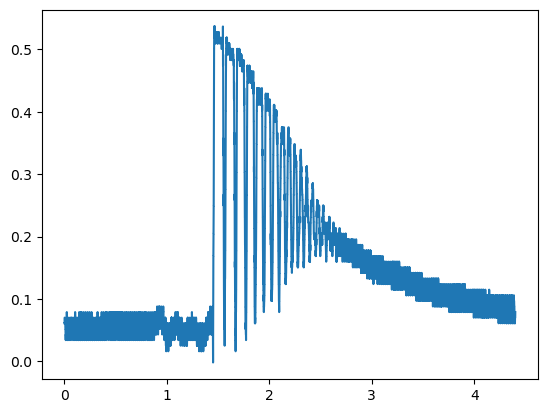

In [31]:
data = pd.read_csv("/Users/a21130/Downloads/Messungen/Messungen mit Barium bei Raumtemperatur/Messung 5 mit d = 10cm und m2.txt",
                   delimiter=';', decimal=",", skiprows=2)

# Kommata durch Punkte ersetzen und die Spalten in float konvertieren
#data = data.replace(',', '.', regex=True).astype(float)

# Umwandeln in ein numpy array
data_np = data.values
plt.plot(data_np[:,0],data_np[:,1])

In [32]:
np.shape(data_np)

(43995, 2)

In [33]:
for i in range(len(data_np) - 2, -1, -1):
    if data_np[i, 1] == data_np[i + 1, 1]:
        data_np = np.delete(data_np, i, axis=0)

In [34]:
np.shape(data_np)

(9074, 2)

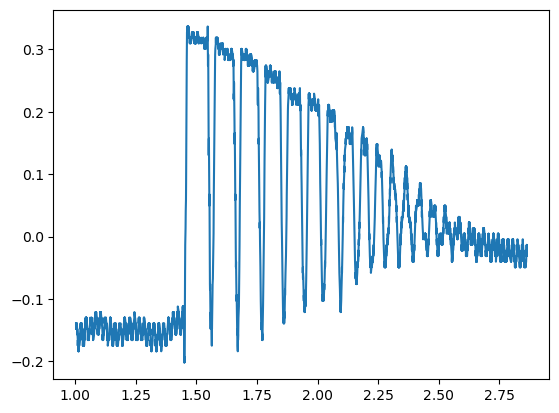

In [35]:
plt.plot(data_np[2000:6000,0],data_np[2000:6000,1]-0.2)

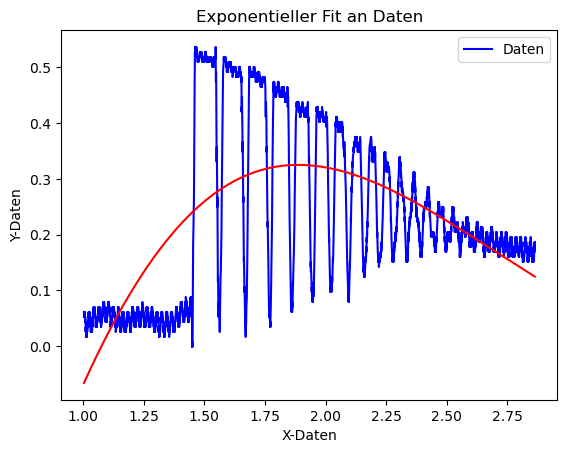

In [36]:

def exponential_function(t, A, b, omega, phi):
    return A * np.exp(-b * t) * np.sin(omega * t + phi)
initial_guess = [100, 0.1, 1.0, 0.0]
# Führe den Fit durch
params, covariance = curve_fit(exponential_function, data_np[2000:6000,0],data_np[2000:6000:,1],p0 = initial_guess, maxfev=50000)

# Extrahiere die angepassten Parameter
A_fit, b_fit, omega_fit, phi_fit = params

# Erzeuge die angepasste Kurve für die Visualisierung
y_fit = exponential_function(data_np[2000:6000,0], A_fit, b_fit, omega_fit, phi_fit)

# Plot der Originaldaten
plt.plot(data_np[2000:6000,0],data_np[2000:6000,1], label='Daten', color='blue')

# Plot der angepassten Kurve
plt.plot(data_np[2000:6000,0], y_fit, color='red')

# Diagramm beschriften
plt.xlabel('X-Daten')
plt.ylabel('Y-Daten')
plt.title('Exponentieller Fit an Daten')
plt.legend()
plt.show()

In [37]:
# Berechne die Fourier-Transformation der Daten
N = len(data_np[:, 1])
T = data_np[1, 0] - data_np[0, 0]  # Zeitintervall
yf = fft(data_np[:, 1])
xf = fftfreq(N, T)[:N//2]

# Plot des Frequenzspektrums
plt.figure(figsize=(10, 6))
plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]), label='Frequenzspektrum')
plt.xlabel('Frequenz (Hz)')
plt.ylabel('Amplitude')
plt.title('Frequenzspektrum der Originaldaten')
plt.legend()
plt.show()

Potenzielle Rauschfrequenzen (Hz): [ 0.          0.29855203  0.59710406  0.89565609  1.19420812  1.49276015
  1.79131218  2.08986421  2.38841624  2.68696827  2.9855203   3.28407233
  3.88117639  4.47828045  4.77683248  5.37393654 49.26108492 49.55963695
 49.85818898 50.15674101 50.45529304 50.75384507]


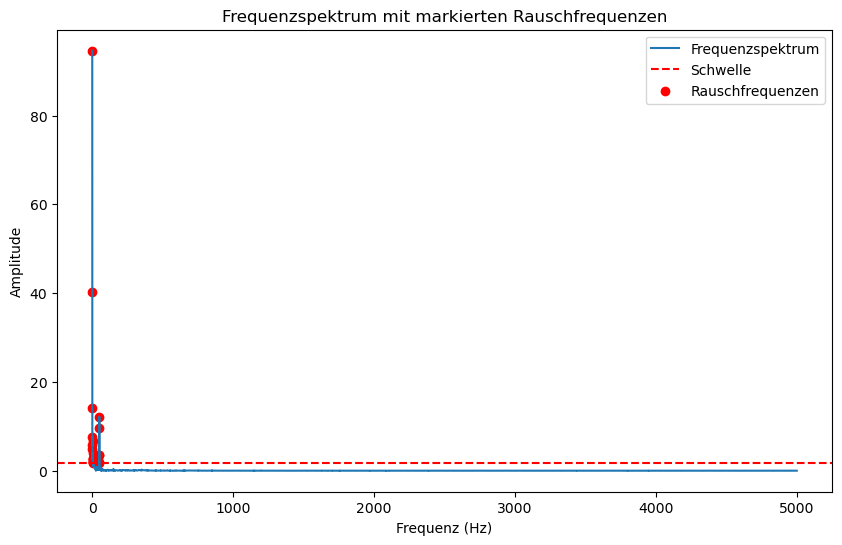

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq

# Beispiel-Daten einlesen (ersetze den Pfad durch deinen tatsächlichen Dateipfad)
data = pd.read_csv("/Users/a21130/Downloads/Messungen/Messungen mit Barium bei Raumtemperatur/Messung 1 mit d = 50cm mit m2.txt",
                   sep=";", decimal=",", skiprows=2)

# Konvertiere den DataFrame in ein Numpy-Array
data_np = data.to_numpy()

# Angenommen, die erste Spalte enthält die Zeitinformationen in Sekunden
time_data = data_np[:, 0]

# Messwerte
signal_data = data_np[:, 1]

# Berechne den mittleren zeitlichen Abstand zwischen den Datenpunkten
time_diffs = np.diff(time_data)
mean_time_diff = np.mean(time_diffs)

# Berechne die Sampling-Rate
fs = 1 / mean_time_diff

# Berechne die Fourier-Transformation der Daten
N = len(signal_data)
yf = fft(signal_data)
xf = fftfreq(N, mean_time_diff)[:N//2]

# Berechne die Amplituden im Frequenzspektrum
amplitudes = 2.0 / N * np.abs(yf[0:N//2])

# Statistische Analyse der Amplituden
mean_amplitude = np.mean(amplitudes)
std_amplitude = np.std(amplitudes)

# Definiere eine Schwelle, um signifikante Peaks zu identifizieren (z.B. Mittelwert + 2*Standardabweichung)
threshold = mean_amplitude + 2 * std_amplitude

# Finde die Frequenzen, die über der Schwelle liegen (potenzielles Rauschen)
noise_frequencies = xf[amplitudes > threshold]

# Ausgabe der potenziellen Rauschfrequenzen
print("Potenzielle Rauschfrequenzen (Hz):", noise_frequencies)

# Plot des Frequenzspektrums mit markierten Rauschfrequenzen
plt.figure(figsize=(10, 6))
plt.plot(xf, amplitudes, label='Frequenzspektrum')
plt.axhline(y=threshold, color='r', linestyle='--', label='Schwelle')
plt.scatter(noise_frequencies, amplitudes[amplitudes > threshold], color='red', label='Rauschfrequenzen')
plt.xlabel('Frequenz (Hz)')
plt.ylabel('Amplitude')
plt.title('Frequenzspektrum mit markierten Rauschfrequenzen')
plt.legend()
plt.show()


In [39]:
time_data = data_np[:, 0]

# Berechne den mittleren zeitlichen Abstand zwischen den Datenpunkten
time_diffs = np.diff(time_data)
mean_time_diff = np.mean(time_diffs)

# Berechne die Sampling-Rate
fs = 1 / mean_time_diff

f0 = 50

# Gütefaktor des Filters
Q = 30.0  # Je höher der Q-Wert, desto schmaler ist der Filter

# Design des Notch-Filters
b, a = iirnotch(f0, Q, fs)

data_filtered = filtfilt(b, a, data_np[:, 1])

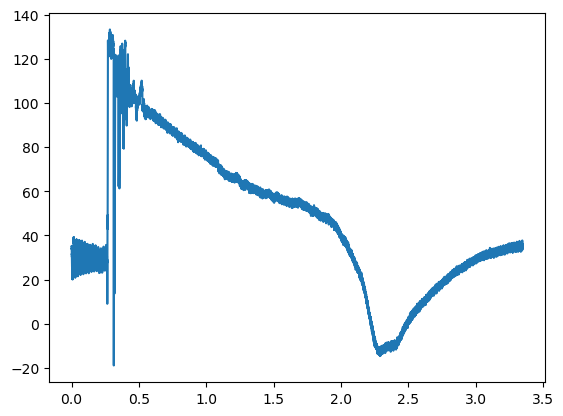

In [40]:
plt.plot(data_np[:,0],data_filtered)

In [41]:
window_size = 50

# Berechne den gleitenden Durchschnitt
moving_avg = np.convolve(data_np[:,1], np.ones(window_size)/window_size, mode='same')

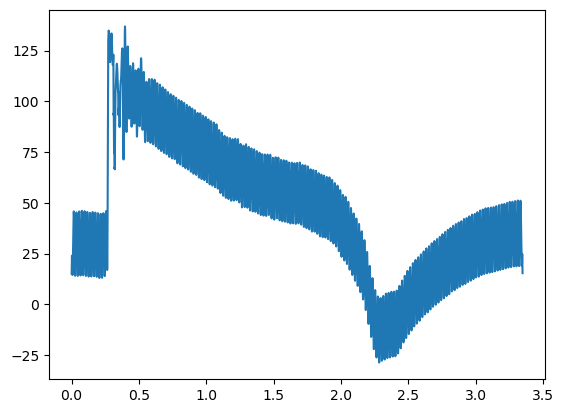

In [44]:
plt.plot(data_np[:,0],moving_avg)

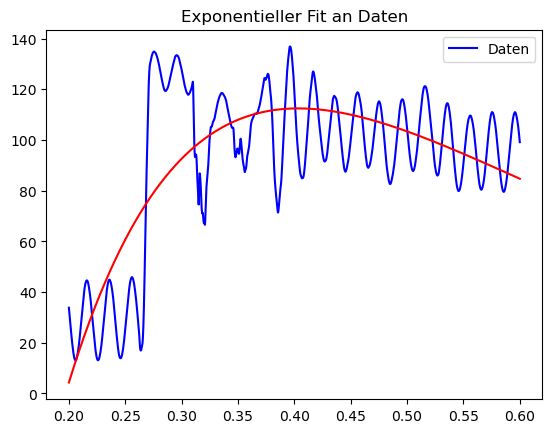

In [43]:

def exponential_function(t, A, b, omega, phi):
    return A * np.exp(-b * t) * np.sin(omega * t + phi)
initial_guess = [100, 0.1, 1.0, 0.0]

params, covariance = curve_fit(exponential_function, data_np[2000:6000,0],moving_avg[2000:6000],p0 = initial_guess, maxfev=50000)

A_fit, b_fit, omega_fit, phi_fit = params

y_fit = exponential_function(data_np[2000:6000,0], A_fit, b_fit, omega_fit, phi_fit)

plt.plot(data_np[2000:6000,0],moving_avg[2000:6000], label='Daten', color='blue')

plt.plot(data_np[2000:6000,0],y_fit, color='red')


plt.title('Exponentieller Fit an Daten')
plt.legend()
plt.show()

In [45]:
np.max(moving_avg)

136.89428199999998